# 1. Install and import depedencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imageio==2.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6


In [ ]:
!pip list

In [ ]:
!pip install opencv-python matplotlib gdown

In [ ]:
import os
import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

In [ ]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 2. Build Data Loading Functions

In [ ]:
def load_video(path: str, augment_flip: bool = True) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        frame = tf.image.rgb_to_grayscale(frame)
        frame = frame[190:236, 80:220, :]

        if augment_flip:
            # Membuat variasi dengan flipping horizontal
            if np.random.rand() > 0.5:
                frame = tf.image.flip_left_right(frame)  # flipping horizontal

        frames.append(frame)

    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std


In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content/drive/MyDrive/Skripsi/datasets/data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content/drive/MyDrive/Skripsi/datasets/data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = './content/drive/MyDrive/Skripsi/datasets/data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 0.07893913],
         [ 0.19734783],
         [ 0.15787826],
         ...,
         [ 1.4209044 ],
         [ 1.460374  ],
         [ 1.460374  ]],

        [[ 0.03946957],
         [ 0.07893913],
         [ 0.15787826],
         ...,
         [ 1.4209044 ],
         [ 1.460374  ],
         [ 1.460374  ]],

        [[ 0.07893913],
         [ 0.07893913],
         [ 0.07893913],
         ...,
         [ 1.3814349 ],
         [ 1.4209044 ],
         [ 1.4209044 ]],

        ...,

        [[ 9.867392  ],
         [ 9.867392  ],
         [ 9.946331  ],
         ...,
         [ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ]],

        [[ 9.867392  ],
         [ 9.867392  ],
         [ 9.906861  ],
         ...,
         [ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ]],

        [[ 9.867392  ],
         [ 9.867392  ],
         [ 9.906861  ],
         ...,
         [ 0.9472696 ],
         [ 0.94726

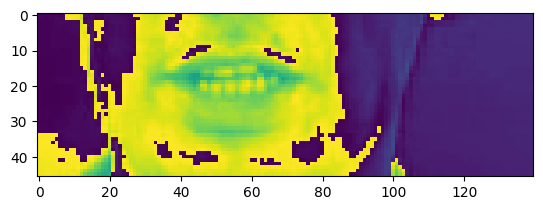

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

NameError: name 'alignments' is not defined

In [ ]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 3. Create Data Pipeline

In [ ]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/Skripsi/datasets/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
#added for split
train = data.take(300)
test = data.skip(300)

In [ ]:
print(train.as_numpy_iterator().next()[0][0].shape)
print(test.as_numpy_iterator().next()[0][0].shape)

(75, 46, 140, 1)
(75, 46, 140, 1)


# 4. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras.metrics import Accuracy

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

KeyboardInterrupt: 

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 5. Setup Training Options and Train

In [ ]:
csv_logger = CSVLogger('/content/drive/MyDrive/Skripsi/training_log6040.csv', append=True)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('/content/drive/MyDrive/Skripsi/sd6040/models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(train)

In [ ]:
model.load_weights('/content/drive/MyDrive/Skripsi/sd6040/models/checkpoint')

In [ ]:
mymodel = model.fit(train, validation_data=test, epochs=25, callbacks=[checkpoint_callback, schedule_callback, example_callback, csv_logger])

Epoch 1/25
1/1 [==============================] - 2s 2s/step
Original: set blue by u zero now
Prediction: set blue by u zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green by y five soon
Prediction: place gren by y five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
300/300 [==============================] - 1893s 6s/step - loss: 1.4935 - val_loss: 2.9429 - lr: 1.0000e-04
Epoch 2/25
1/1 [==============================] - 0s 71ms/step
Original: lay red with z sp two now
Prediction: lay red with z p two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red in a seven soon
Prediction: set red in a seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
300/300 [==============================] - 279s 930ms/step - loss: 1.3119 - val_

In [ ]:
model.save('/content/drive/MyDrive/Skripsi/sd6040/trained/model200', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


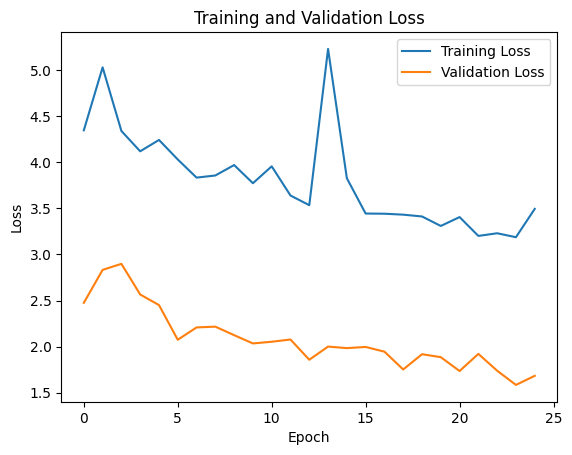

In [ ]:
# Mendapatkan riwayat loss pelatihan dari objek History
train_loss = mymodel.history['loss']

# Mendapatkan riwayat loss validasi dari objek History
val_loss = mymodel.history['val_loss']

# Plot metrik loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.load_weights('/content/drive/MyDrive/Skripsi/sd6040/trained/model150/checkpoint')

DataLossError: {{function_node __wrapped__RestoreV2_dtypes_22_device_/job:localhost/replica:0/task:0/device:CPU:0}} TensorBundle at /content/drive/MyDrive/Skripsi/sd6040/trained/model150/checkpoint shard 0 (13824 bytes): Checksum does not match: stored 4053279116 vs. calculated on the restored bytes 1738609507 [Op:RestoreV2]

In [ ]:
from keras.models import load_model
from keras.utils import custom_object_scope

with custom_object_scope({'CTCLoss': CTCLoss}):
    model = load_model('/content/drive/MyDrive/Skripsi/sd6040/trained/model100')

OSError: Unable to open file (file signature not found)

In [ ]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.3 MB/s eta 0:00:00


In [ ]:
import Levenshtein
import numpy as np
import tensorflow as tf

def compute_wer(true_label, predicted_label):
    true_words = true_label.split()
    pred_words = predicted_label.split()
    wer = Levenshtein.distance(' '.join(true_words), ' '.join(pred_words))
    wer /= len(true_words)
    return wer

def compute_cer(true_label, predicted_label):
    cer = Levenshtein.distance(true_label, predicted_label)
    cer /= len(true_label)
    return cer

def compute_accuracy_wer_cer(model, test_data, test_labels):
    correct_predictions = 0
    total_samples = len(test_labels)
    true_labels = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in test_labels]

    total_wer = 0
    total_cer = 0

    for i in range(total_samples):
        test_data_with_batch = np.expand_dims(test_data[i], axis=0)
        predictions = model.predict(test_data_with_batch)

        try:
            decoded = tf.keras.backend.ctc_decode(predictions, input_length=[75], greedy=True)[0][0].numpy()
            predicted_labels = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in decoded]

            true_label_str = true_labels[i]
            predicted_label_str = predicted_labels[0]

            wer = compute_wer(true_label_str, predicted_label_str)
            cer = compute_cer(true_label_str, predicted_label_str)
            total_wer += wer
            total_cer += cer

            if np.array_equal(true_label_str, predicted_label_str):
                correct_predictions += 1
        except Exception as e:
            print(f"Error occurred for sample {i + 1} : {e}")
            continue

    accuracy = correct_predictions / total_samples
    average_wer = total_wer / total_samples
    average_cer = total_cer / total_samples
    return "Akurasi:", accuracy, "Akurasi WER (Word Error Rate):", average_wer, "Akurasi CER (Character Error Rate):", average_cer

In [ ]:
import glob
import random

# Tentukan pola nama file
file_pattern = '/content/drive/MyDrive/Skripsi/datasets/data/s1/*.mpg'

# Dapatkan daftar file yang cocok dengan pola
file_list = glob.glob(file_pattern)

# Function to load CSV and get file paths
def load_csv(file):
    df = pd.read_csv(file)
    return df["file_path"].tolist()

# Load test file paths from CSV
# test_file_paths = load_csv('/content/drive/MyDrive/Skripsi/datasets/test_paths.csv')

# Load data dari file-file tersebut
test_data = []
test_labels = []

for file_path in file_list:
    # Lakukan proses load data sesuai dengan kebutuhan Anda
    frames, alignments = load_data(tf.convert_to_tensor(file_path))

    test_data.append(frames)
    test_labels.append(alignments)

In [ ]:
test_accuracy = compute_accuracy_wer_cer(model, test_data, test_labels)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 1s 1s/step
Error occurred for sample 363 : {{function_node __wrapped__CTCGreedyDecoder_device_/job:localhost/replica:0/task:0/device:CPU:0}} sequence_length(0) <= 74 [Op:CTCGreedyDecoder] name: 
1/1 [==============================] - 0s 48ms/step
Error occurred for sample 763 : {{function_node __wrapped__CTCGreedyDecoder_device_/job:localhost/replica:0/task:0/device:CPU:0}} sequence_length(0) <= 74 [Op:CTCGreedyDecoder] name: 
1/1 [==============================] - 0s 45ms/step
Error occurred for sample 888 : {{function_node __wrapped__CTCGreedyDecoder_device_/job:localhost/replica:0/task:0/device:CPU:0}} sequence_length(0) <= 74 [Op:CTCGreedyDecoder] name: 
1/1 [==============================] - 0s 45ms/step
Error occurred for sample 927 : {{function_node __wrapped__CTCGreedyDecoder_device_/job:localhost/replica:0/task:0/device:CPU:0}} sequence_length(0) <= 74 [Op:CTCGreedyDecoder] name: 
1/1 [==============================] - 0s 45ms/step
Error 

In [ ]:
test_batch = next(test)  # Fetch the next batch of data from the NumpyIterator
test_data = test_batch[0]  # Extract the data from the batch
test_labels = test_batch[1]  # Extract the labels from the batch

StopIteration: 

In [ ]:
test_data = data.as_numpy_iterator()
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 44s 44s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green by y seven again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green at q seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with e eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue with o zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with l zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red in n seven again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f zero now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green by y seven again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green at q seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with e eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue with o zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with l zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red in n seven again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f zero now'>]

In [ ]:
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return tokens[1:]

In [ ]:
def collect_unique_labels(alignment_dir: str) -> List[str]:
    unique_labels = set()
    for root, dirs, files in os.walk(alignment_dir):
        for file in files:
            if file.endswith('.align'):
                alignment_path = os.path.join(root, file)
                labels = load_alignments(alignment_path)
                unique_labels.update(labels)
    return sorted(list(unique_labels))

# Misalkan path alignment berada di '/content/drive/MyDrive/Skripsi/datasets/data/alignments/s1'
alignment_dir = '/content/drive/MyDrive/Skripsi/datasets/data/alignments/s1'
class_names = collect_unique_labels(alignment_dir)

print("Class names:", class_names)

Class names: [' ', 'a', 'again', 'at', 'b', 'bin', 'blue', 'by', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'green', 'h', 'i', 'in', 'j', 'k', 'l', 'lay', 'm', 'n', 'nine', 'now', 'o', 'one', 'p', 'place', 'please', 'q', 'r', 'red', 's', 'set', 'seven', 'six', 'soon', 'sp', 't', 'three', 'two', 'u', 'v', 'white', 'with', 'x', 'y', 'z', 'zero']


In [ ]:
len(class_names)

53

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from typing import List, Tuple

def load_video(path: str, augment_flip: bool = True) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frame = frame[190:236, 80:220, :]
        if augment_flip and np.random.rand() > 0.5:
            frame = tf.image.flip_left_right(frame)  # flipping horizontal
        frames.append(frame)

    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return tokens

def load_data(path: str) -> Tuple[List[float], List[int]]:
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content/drive/MyDrive/Skripsi/datasets/data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content/drive/MyDrive/Skripsi/datasets/data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, char_to_num(tf.reshape(tf.strings.unicode_split(alignments, input_encoding='UTF-8'), (-1)))[1:]

def mappable_function(path: str) -> Tuple[tf.Tensor, tf.Tensor]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

data = tf.data.Dataset.list_files('/content/drive/MyDrive/Skripsi/datasets/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(8, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Split data into training and test sets
train = data.take(0)
test = data.skip(0)

# Load model
from keras.models import load_model
from keras.utils import custom_object_scope

with custom_object_scope({'CTCLoss': CTCLoss}):
    model = load_model('/content/drive/MyDrive/Skripsi/bs8/trained/model150')

# Get the test labels
test_labels = []
for batch in test:
    _, labels = batch
    for label in labels:
        label_str = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        test_labels.append(label_str)

print("Test labels:", test_labels)

Test labels: ['set green by j two please', 'bin red with a three soon', 'bin red in z six now', 'lay red by l zero now', 'bin white with b one again', 'place green at q six now', 'set red at u two now', 'place white with y three soon', 'set red by b five soon', 'place red in i eight please', 'set green in v two please', 'lay green by m three soon', 'set blue by n nine again', 'lay white at z one soon', 'bin red by a zero please', 'place blue with p eight please', 'bin blue in z one soon', 'lay white by z six please', 'place red by p eight now', 'lay red at y five soon', 'bin white in m six please', 'set white in h seven soon', 'set white by o eight now', 'set white with j one again', 'bin green by o zero please', 'lay white at l four please', 'lay red with f zero now', 'place red at x one again', 'place green in j nine soon', 'lay green in r nine soon', 'bin green by h five soon', 'set blue with h seven soon', 'place white with q eight now', 'place green at y zero now', 'set green by j

In [ ]:
len(test_labels)

1000

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fungsi untuk memuat data uji (test data)
def load_test_data(test_labels):
    # Implementasi load data uji sesuai dengan struktur data Anda
    # Placeholder untuk data uji
    test_videos = np.random.rand(200, 75, 46, 140, 1)  # Ganti dengan data uji Anda
    test_labels = test_labels
    return test_videos, test_labels

# Memuat data uji
test_videos, test_labels = load_test_data(test_labels)

# Membuat prediksi menggunakan model
model = tf.keras.models.load_model('/content/drive/MyDrive/Skripsi/bs8/trained/model150', custom_objects={'CTCLoss': CTCLoss})
predictions = model.predict(test_videos[0])

# Konversi prediksi ke bentuk string
def decode_predictions(predictions):
    decoded_predictions = []
    for pred in predictions:
        decoded_string = tf.strings.reduce_join([num_to_char(tf.argmax(word)) for word in pred], separator=' ').numpy().decode('utf-8')
        decoded_predictions.append(decoded_string)
    return decoded_predictions

decoded_predictions = decode_predictions(predictions)

# Gunakan class_names yang sudah Anda buat sebelumnya
class_names = collect_unique_labels('/content/drive/MyDrive/Skripsi/datasets/data/alignments/s1')

# Karena label dan prediksi adalah string, kita perlu mengonversinya ke indeks kelas
def label_to_index(labels, class_names):
    label_indices = []
    for label in labels:
        indices = [class_names.index(token) for token in label.split()]
        label_indices.append(indices)
    return label_indices

true_indices = label_to_index(test_labels, class_names)
pred_indices = label_to_index(decoded_predictions, class_names)

# Flatten list of indices to get single label for each sample
true_indices_flat = [item for sublist in true_indices for item in sublist]
pred_indices_flat = [item for sublist in pred_indices for item in sublist]

# Confusion Matrix
conf_matrix = confusion_matrix(true_indices_flat, pred_indices_flat, labels=range(len(class_names)))

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(include_values=True, xticks_rotation='vertical', cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 75, 46, 140, 1), found shape=(None, 46, 140, 1)


In [ ]:
sample = load_data(tf.convert_to_tensor('./content/drive/MyDrive/Skripsi/datasets/data/s1/bras9a.mpg'))

print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

1/1 [==============================] - 0s 147ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]